In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util

import seaborn as sns
import pandas as pd
from dstools import plot

## Load model

In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

path_to_model = '/home/Edu/shengao-aug1/detect.ckpt'
path_to_model = '/home/Edu/cat-july19/detect.ckpt'
model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)

## Template loading

In [15]:
path_to_ground_truth = str(Path('~/data/groundtruth_ej49_data1_set1.mat').expanduser())

kk = io.loadmat(path_to_ground_truth)

# L_gt has length total number of spikes; it is the cluster index for each spike
# spt_gt has length total number of spikes; it is the time for each spike
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] + 10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)

min_amp = 2
max_amp = 60
n_clean_per_template = 400 * 5


path_to_standarized = str(Path('~/data/tmp/preprocess/standarized.bin').expanduser())

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 41, 42, 43, 44, 45, 46,
                    47, 48]

n_templates = np.max(spike_train[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [6]:
processor = TemplatesProcessor.from_spike_train(CONFIG,
                                                4 * CONFIG.spike_size,
                                                spike_train,
                                                path_to_standarized)

100%|██████████| 3/3 [00:24<00:00,  8.02s/it]


In [8]:
aligned = processor.align(CONFIG.spike_size)

In [9]:
cropped = processor.crop_spatially(CONFIG.neigh_channels, CONFIG.geom)

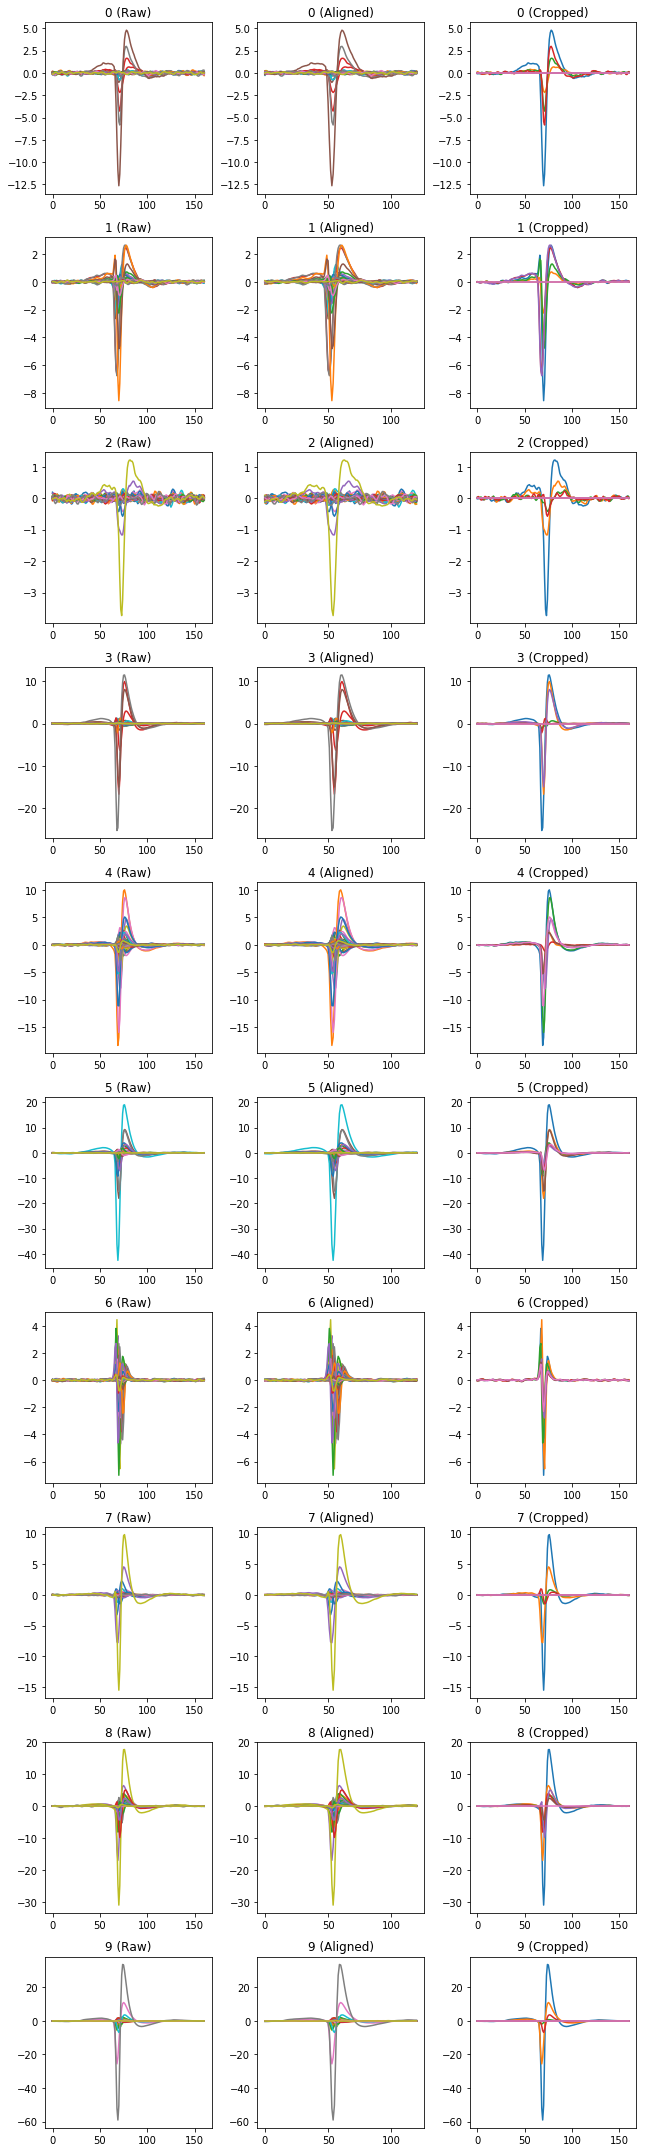

In [10]:
plot.grid_from_array([processor.values,
                      aligned.values, cropped.values],
                     axis=0,
                     elements=range(10),
                     auto_figsize=3,
                     group_names=('Raw', 'Aligned', 'Cropped'))

In [11]:
small = cropped.crop_temporally(30)
small.values.shape

(49, 61, 7)

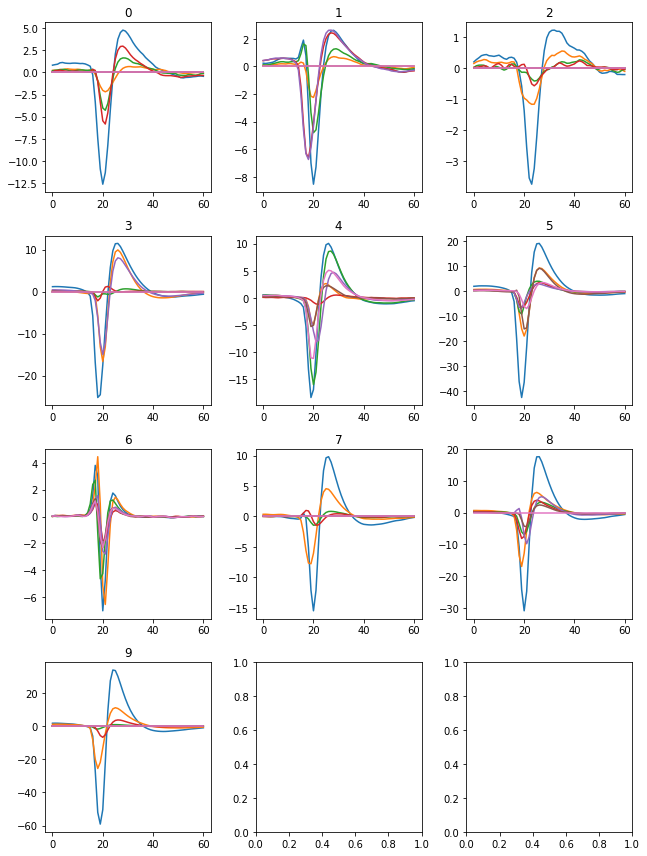

In [12]:
plot.grid_from_array(small.values,
                     axis=0,
                     elements=range(10),
                     auto_figsize=3)

## Generate testing data

In [16]:
dataset = Dataset.make(0.5, small.values,
                       min_amp, max_amp,
                       path_to_standarized,
                       n_clean_per_template,
                       CONFIG.geom,
                       make_spatially_misaligned=False,
                       make_temporally_misaligned=False,
                       make_collided=False,
                       make_noise=True)

In [106]:
dataset.stats

{'from templates': 98000, 'noise': 98000}

In [107]:
dataset.df_noisy.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group
0,"[[1.2354820617916762, -0.3189821045290263, 0.2...",3.319401,from templates,5.356339,3.390,5.415
1,"[[0.8911107928082731, 0.17429240662017104, 2.0...",4.812287,from templates,8.572153,7.940,9.069
2,"[[0.951921311307466, 0.3250627987364903, -0.76...",2.702287,from templates,5.169796,2.749,5.224
3,"[[0.13126996945026267, -1.9702209102524106, -0...",3.258437,from templates,5.252780,3.281,5.323
4,"[[2.3038011325102143, 0.2827165903450208, 2.48...",3.871652,from templates,6.648620,4.115,6.953


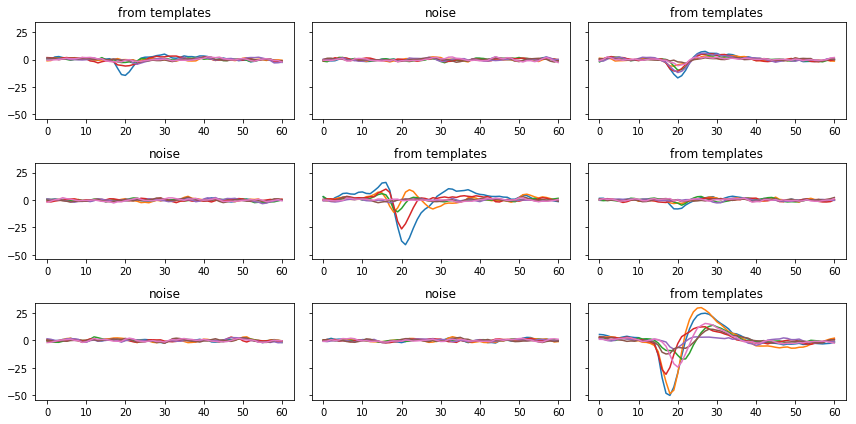

In [111]:
plot.grid_from_array(dataset.data_noisy, axis=0,
                     elements=9,
                     labels=dataset.df_noisy.kind,
                     auto_figsize=(4, 2),
                     sharey=True)

## Predict on templates

In [114]:
preds = ['{:.2f}'.format(p) for p in model.predict_proba(small.values)]

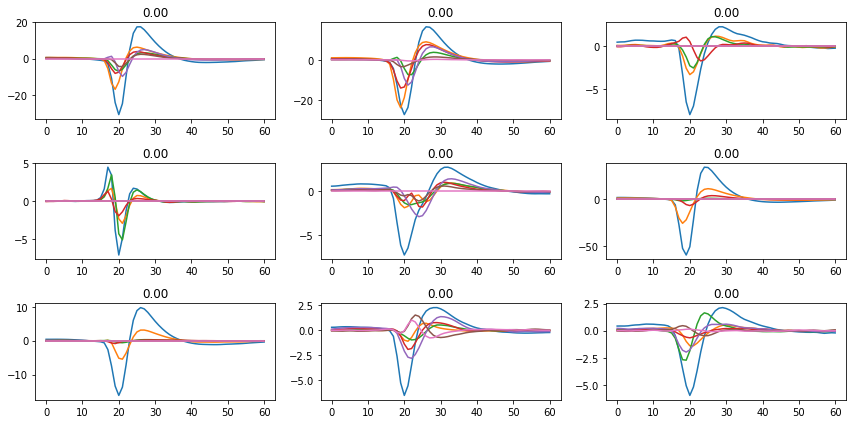

In [119]:
plot.grid_from_array(small.values,
                     axis=0,
                     elements=9,
                     auto_figsize=(4, 2),
                     labels=preds)

## Predicting on shifted waveforms

In [120]:
all_channels = aligned.crop_temporally(20)
model.predict_recording(all_channels.values[0])

[array([], shape=(0, 2), dtype=int32)]

In [121]:
def shifter_generator(x, waveform_length, step):
    original_wf_length, n_channels = x.shape    
    n = int((original_wf_length - waveform_length)/step + 1)

    shifted = np.zeros((n, waveform_length, n_channels))
    
    for i in range(n):
        shifted[i, :, :] = x[(i * step):waveform_length + (i * step), :]
    
    return shifted

def predict_plot(model, x):
    preds = ['{:.2f}'.format(p) for p in model.predict(x)]

    plot.grid_from_array(x,
                         axis=0,
                         auto_figsize=3,
                         labels=preds)


def shift_predict_plot(x, waveform_length, step, model):
    shifted = shifter_generator(x, waveform_length, step)
    predict_plot(model, shifted)

In [122]:
cropped.values[0].shape

(161, 7)

In [123]:
# shifted = shifter_generator(cropped.values[0], 41, step=4)

names = ('spike_index', 'probability', 'waveform')
spike_index, prob, wave = model.predict_recording(cropped.values[0],
                                                  output_names=names)

In [124]:
spike_index.shape, prob.shape, wave.shape

((10, 2), (161, 49), (10, 61, 19))

In [125]:
spike_index

array([[74,  4],
       [74,  5],
       [75,  0],
       [75,  1],
       [75,  2],
       [75,  3],
       [75,  7],
       [75, 11],
       [75, 14],
       [75, 15]], dtype=int32)

In [126]:
cropped.values[0].shape

(161, 7)

In [127]:
prob.shape

(161, 49)

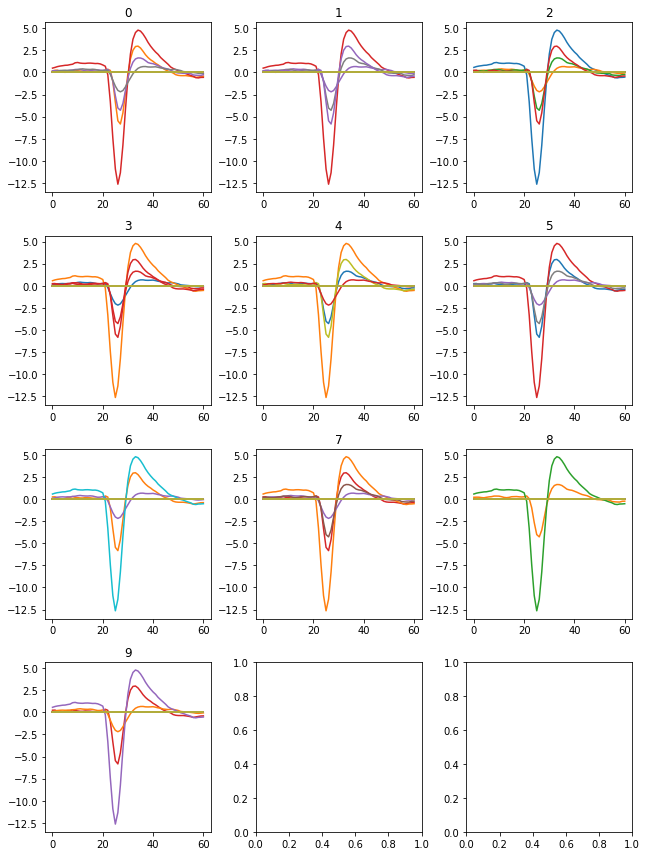

In [128]:
plot.grid_from_array(wave, axis=0, auto_figsize=3)

In [129]:
shift_predict_plot(cropped.values[0], 41, step=4, model=model)

ValueError: waveform length from network (61) does not match input data (41)

## Passing pure noise

In [18]:
noise = augment_util.make_noise((500000, 61, 7), dataset.spatial_sig, dataset.temporal_sig)

In [19]:
# noise = dataset.data_noisy[dataset.slices['noise']]
n_noise = noise.shape[0]
print('Noise shape: ', noise.shape)

Noise shape:  (500000, 61, 7)


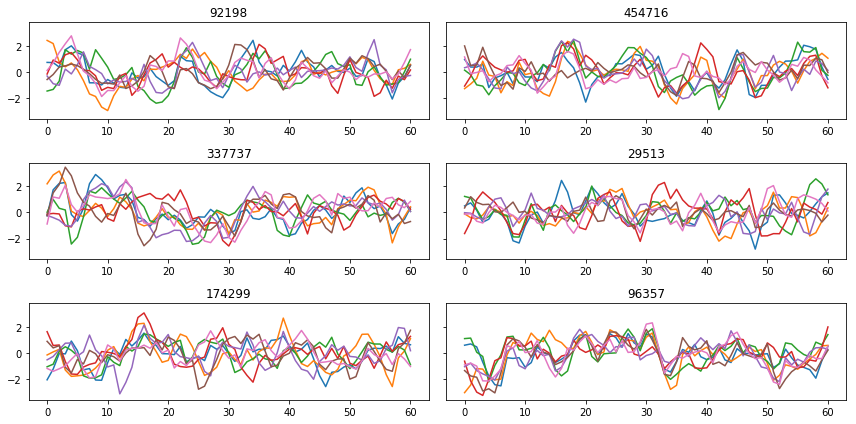

In [20]:
plot.grid_from_array(noise, axis=0, elements=6,
                     auto_figsize=(6, 2), sharey=True)

In [21]:
probas = model.predict_proba(noise)

In [22]:
higher_than_zero = noise[probas > 0.01]
higher_than_one_half = noise[probas > 0.5]

fpr = len(higher_than_one_half)/n_noise

print('{} ({:.4f}) [>0.01], {} ({:.4f})[>0.5]'.format(len(higher_than_zero), len(higher_than_zero)/n_noise,
                                              len(higher_than_one_half), fpr))

14598 (0.0292) [>0.01], 2029 (0.0041)[>0.5]


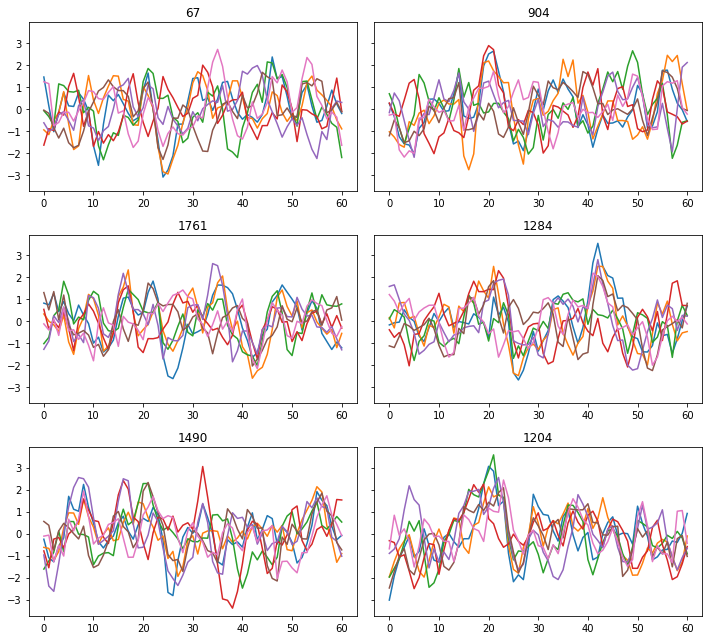

In [32]:
plot.grid_from_array(higher_than_one_half, axis=0,
                     auto_figsize=(5, 3), sharey=True,
                     elements=6)

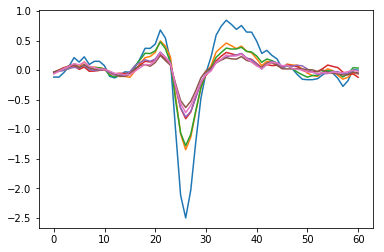

In [24]:
noise_mean_wf = higher_than_one_half.mean(axis=0)
_ = plt.plot(noise_mean_wf)

In [33]:
noise_df = dataset.get_kind('noise', units_per_bin=0.5).df_noisy

# add labels
_ = {'noise': 0}

noise_df['label'] = noise_df.kind.replace(_)

noise_df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[0.13563008511681712, -0.24560836560691102, 1...",2.600700,noise,5.032729,2.757,5.163,0
1,"[[-0.47038941168339654, -1.29529477676865, -0....",3.513428,noise,6.408303,3.654,6.446,0
2,"[[2.0435878610977976, 2.327676090562805, -0.68...",3.098038,noise,5.410251,3.149,5.410,0
3,"[[0.344493749675561, -0.5670214304743454, -1.0...",2.658218,noise,5.037552,2.757,5.163,0
4,"[[2.2500642242532773, 3.518131585583484, 0.266...",3.770559,noise,6.602234,6.156,9.756,0


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


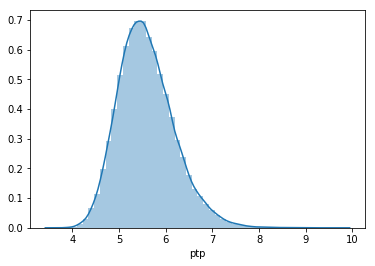

In [37]:
sns.distplot(noise_df.ptp)

In [45]:
def prop(preds, group):
    return (1 - (preds == group.label).mean())

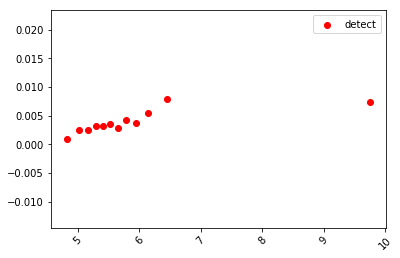

In [46]:
x, y = evaluate.compute_per_group(noise_df, 'ptp_group',
                                  model.predict, prop)

# plot results
# label=model.model_name
_ = plt.scatter(x, y, color='r', label='detect')

_ = plt.legend()
_ = plt.xticks(rotation=45)

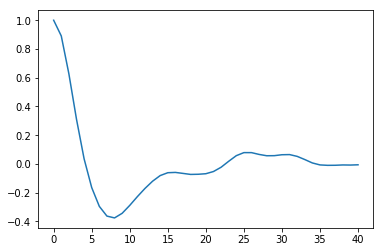

In [28]:
autocorrelation = acf(noise_mean_wf[:, 0])
_ = plt.plot(autocorrelation)

## Predict on recordings

## Metrics vs SNR

In [140]:
df = dataset.df_noisy
df['label'] = df.kind.replace({'from templates': 1, 'noise': 0})
df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[1.2354820617916762, -0.3189821045290263, 0.2...",3.319401,from templates,5.356339,3.390,5.415,1
1,"[[0.8911107928082731, 0.17429240662017104, 2.0...",4.812287,from templates,8.572153,7.940,9.069,1
2,"[[0.951921311307466, 0.3250627987364903, -0.76...",2.702287,from templates,5.169796,2.749,5.224,1
3,"[[0.13126996945026267, -1.9702209102524106, -0...",3.258437,from templates,5.252780,3.281,5.323,1
4,"[[2.3038011325102143, 0.2827165903450208, 2.48...",3.871652,from templates,6.648620,4.115,6.953,1


In [141]:
def accuracy(preds, group):
    return metrics.accuracy_score(group.label, preds)

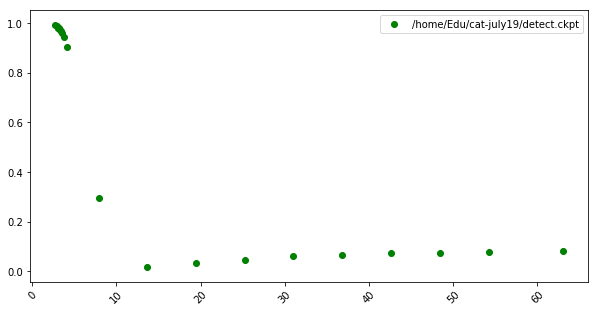

In [145]:
# pass spikes and make predictions
amps, props = evaluate.compute_per_group(df, 'amplitude_group',
                                         model.predict,
                                         accuracy)

# plot results
_ = plt.scatter(amps, props, color=colors[i],
                label=path_to_model)
_ = plt.legend()
_ = plt.xticks(rotation=45)